Dataset Info.  

train.csv [파일]  
ID : 샘플별 고유 ID  
Age : 환자의 나이  
Gender : 성별  
Country : 국적  
Race : 인종  
Family_Background : 가족력 여부  
Radiation_History : 방사선 노출 이력  
Iodine_Deficiency : 요오드 결핍 여부  
Smoke : 흡연 여부  
Weight_Risk : 체중 관련 위험도  
Diabetes : 당뇨병 여부  
Nodule_Size : 갑상선 결절 크기  
TSH_Result : TSH 호르몬 검사 결과  
T4_Result : T4 호르몬 검사 결과  
T3_Result : T3 호르몬 검사 결과  
Cancer : 갑상선암 여부 (0: 양성, 1: 악성)  


test.csv [파일]  
ID : 샘플별 고유 ID  
Cancer를 제외한 train.csv와 동일한 형태  


sample_submission.csv [파일] - 제출 양식  
ID : 샘플별 고유 ID  
Cancer : 갑상선암 여부 (0: 양성, 1: 악성)  

## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

## 데이터 읽어오기

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87159 entries, 0 to 87158
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 87159 non-null  object 
 1   Age                87159 non-null  int64  
 2   Gender             87159 non-null  object 
 3   Country            87159 non-null  object 
 4   Race               87159 non-null  object 
 5   Family_Background  87159 non-null  object 
 6   Radiation_History  87159 non-null  object 
 7   Iodine_Deficiency  87159 non-null  object 
 8   Smoke              87159 non-null  object 
 9   Weight_Risk        87159 non-null  object 
 10  Diabetes           87159 non-null  object 
 11  Nodule_Size        87159 non-null  float64
 12  TSH_Result         87159 non-null  float64
 13  T4_Result          87159 non-null  float64
 14  T3_Result          87159 non-null  float64
 15  Cancer             87159 non-null  int64  
dtypes: float64(4), int64(2

In [4]:
train.head()

,ID,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result,Cancer
0,TRAIN_00000,80,M,CHN,ASN,Positive,Exposed,Sufficient,Non-Smoker,Not Obese,No,0.650355,2.784735,6.744603,2.575820,1
1,TRAIN_00001,37,M,NGA,ASN,Positive,Unexposed,Sufficient,Smoker,Obese,No,2.950430,0.911624,7.303305,2.505317,1
2,TRAIN_00002,71,M,CHN,MDE,Positive,Unexposed,Sufficient,Non-Smoker,Not Obese,Yes,2.200023,0.717754,11.137459,2.381080,0
3,TRAIN_00003,40,F,IND,HSP,Negative,Unexposed,Sufficient,Non-Smoker,Obese,No,3.370796,6.846380,10.175254,0.753023,0
4,TRAIN_00004,53,F,CHN,CAU,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,No,4.230048,0.439519,7.194450,0.569356,1


## 결측치 확인

In [5]:
train.isnull().sum()

ID                   0
Age                  0
Gender               0
Country              0
Race                 0
Family_Background    0
Radiation_History    0
Iodine_Deficiency    0
Smoke                0
Weight_Risk          0
Diabetes             0
Nodule_Size          0
TSH_Result           0
T4_Result            0
T3_Result            0
Cancer               0
dtype: int64

## EDA

In [6]:
train = train.drop(columns=['ID'])

In [7]:
train.head(5)

,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result,Cancer
0,80,M,CHN,ASN,Positive,Exposed,Sufficient,Non-Smoker,Not Obese,No,0.650355,2.784735,6.744603,2.575820,1
1,37,M,NGA,ASN,Positive,Unexposed,Sufficient,Smoker,Obese,No,2.950430,0.911624,7.303305,2.505317,1
2,71,M,CHN,MDE,Positive,Unexposed,Sufficient,Non-Smoker,Not Obese,Yes,2.200023,0.717754,11.137459,2.381080,0
3,40,F,IND,HSP,Negative,Unexposed,Sufficient,Non-Smoker,Obese,No,3.370796,6.846380,10.175254,0.753023,0
4,53,F,CHN,CAU,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,No,4.230048,0.439519,7.194450,0.569356,1


In [8]:
test.head(5)

,ID,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result
0,TEST_00000,53,M,NGA,CAU,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,No,2.940678,6.434501,9.227958,2.733846
1,TEST_00001,46,M,KOR,MDE,Negative,Unexposed,Deficient,Smoker,Obese,No,3.450129,4.729535,5.937664,0.775012
2,TEST_00002,78,F,IND,ASN,Negative,Exposed,Sufficient,Non-Smoker,Obese,No,4.680720,5.663475,10.455964,1.259896
3,TEST_00003,69,F,KOR,CAU,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,No,4.280588,7.473752,8.785335,2.826138
4,TEST_00004,77,F,KOR,CAU,Positive,Unexposed,Sufficient,Non-Smoker,Obese,No,3.380094,7.099987,8.737063,3.453563


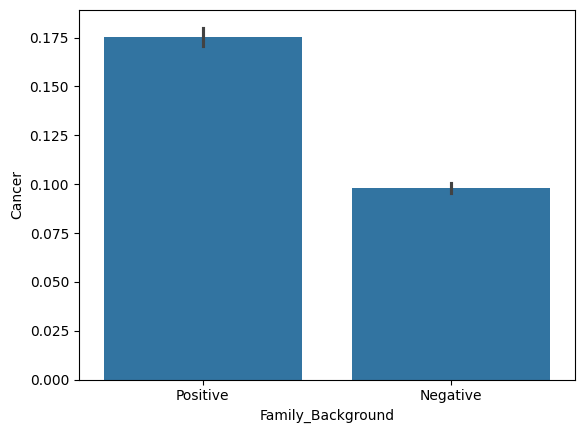

In [9]:
sbp = sns.barplot(x = "Family_Background", y = "Cancer", data = train)

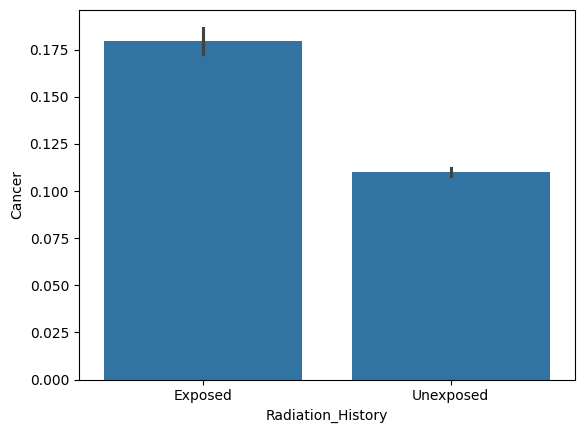

In [10]:
sbp = sns.barplot(x = "Radiation_History", y = "Cancer", data = train)

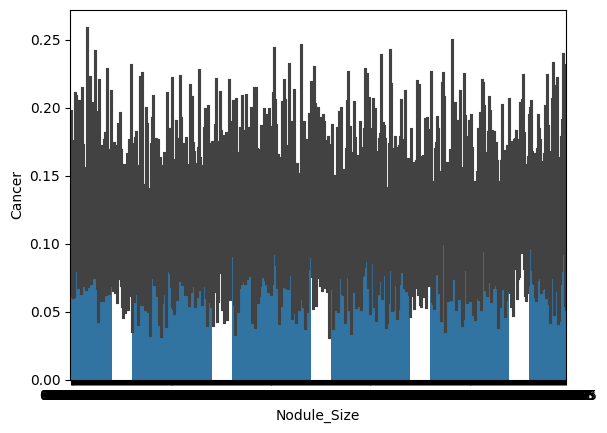

In [11]:
sbp = sns.barplot(x = "Nodule_Size", y = "Cancer", data = train)

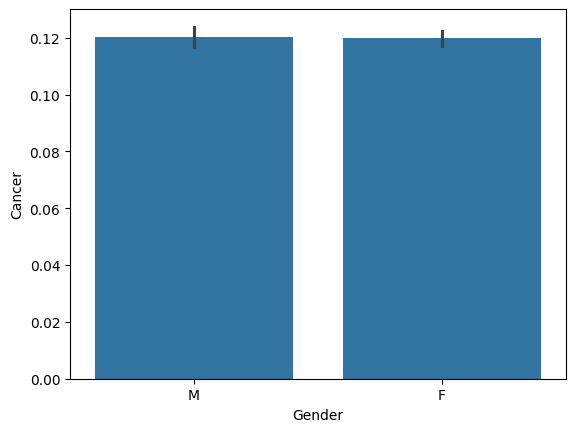

In [12]:
sbp = sns.barplot(x = "Gender", y = "Cancer", data = train)

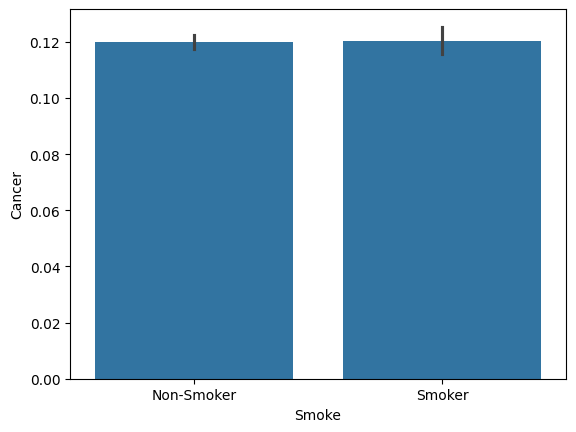

In [13]:
sbp = sns.barplot(x = "Smoke", y = "Cancer", data = train)

In [14]:
pd.crosstab(train["Gender"], train["Cancer"], margins = True) 

Cancer,0,1,All
Gender,,,
F,45987,6261,52248
M,30713,4198,34911
All,76700,10459,87159


In [15]:
pd.crosstab(train["Nodule_Size"], train["Cancer"], margins = True) 

Cancer,0,1,All
Nodule_Size,,,
0.0,71,10,81
0.010324,155,22,177
0.020164,164,18,182
0.030125,153,19,172
0.040064,130,16,146
...,...,...,...
4.970265,115,23,138
4.980303,143,30,173
4.990595,147,17,164


In [16]:
pd.crosstab(train["TSH_Result"], train["Cancer"], margins = True) 

Cancer,0,1,All
TSH_Result,,,
0.1,42,0,42
0.111002,0,1,1
0.11102,1,0,1
0.111037,1,0,1
0.111084,0,1,1
...,...,...,...
9.99993,0,1,1
9.999981,1,0,1
9.999995,1,0,1


In [17]:
pd.crosstab(train["T4_Result"], train["Cancer"], margins = True) 

Cancer,0,1,All
T4_Result,,,
4.5,52,12,64
4.511071,1,0,1
4.511224,1,0,1
4.51131,1,0,1
4.51142,0,1,1
...,...,...,...
11.999844,1,0,1
11.999845,1,0,1
11.999873,1,0,1


In [18]:
pd.crosstab(train["T3_Result"], train["Cancer"], margins = True) 

Cancer,0,1,All
T3_Result,,,
0.5,138,19,157
0.511081,1,0,1
0.511089,1,0,1
0.51111,1,0,1
0.511124,1,0,1
...,...,...,...
3.499898,1,0,1
3.49994,1,0,1
3.499987,1,0,1


In [19]:
train

,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result,Cancer
0,80,M,CHN,ASN,Positive,Exposed,Sufficient,Non-Smoker,Not Obese,No,0.650355,2.784735,6.744603,2.575820,1
1,37,M,NGA,ASN,Positive,Unexposed,Sufficient,Smoker,Obese,No,2.950430,0.911624,7.303305,2.505317,1
2,71,M,CHN,MDE,Positive,Unexposed,Sufficient,Non-Smoker,Not Obese,Yes,2.200023,0.717754,11.137459,2.381080,0
3,40,F,IND,HSP,Negative,Unexposed,Sufficient,Non-Smoker,Obese,No,3.370796,6.846380,10.175254,0.753023,0
4,53,F,CHN,CAU,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,No,4.230048,0.439519,7.194450,0.569356,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87154,65,F,IND,ASN,Positive,Unexposed,Sufficient,Non-Smoker,Not Obese,No,0.510802,3.786859,4.838150,0.625754,1
87155,53,M,NGA,ASN,Negative,Unexposed,Sufficient,Non-Smoker,Obese,No,0.980413,4.335395,8.937716,2.728584,0
87156,29,F,RUS,CAU,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,No,0.180998,5.724924,4.847265,3.318609,0
87157,52,F,IND,ASN,Positive,Unexposed,Sufficient,Non-Smoker,Not Obese,No,2.420773,4.978069,10.867191,2.259199,1


In [20]:
drop_columns = ['Age', 'Country', 'Race', 'Smoke', 'Weight_Risk', "Diabetes"]

train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)

In [21]:
train

,Gender,Family_Background,Radiation_History,Iodine_Deficiency,Nodule_Size,TSH_Result,T4_Result,T3_Result,Cancer
0,M,Positive,Exposed,Sufficient,0.650355,2.784735,6.744603,2.575820,1
1,M,Positive,Unexposed,Sufficient,2.950430,0.911624,7.303305,2.505317,1
2,M,Positive,Unexposed,Sufficient,2.200023,0.717754,11.137459,2.381080,0
3,F,Negative,Unexposed,Sufficient,3.370796,6.846380,10.175254,0.753023,0
4,F,Negative,Unexposed,Sufficient,4.230048,0.439519,7.194450,0.569356,1
...,...,...,...,...,...,...,...,...,...
87154,F,Positive,Unexposed,Sufficient,0.510802,3.786859,4.838150,0.625754,1
87155,M,Negative,Unexposed,Sufficient,0.980413,4.335395,8.937716,2.728584,0
87156,F,Negative,Unexposed,Sufficient,0.180998,5.724924,4.847265,3.318609,0
87157,F,Positive,Unexposed,Sufficient,2.420773,4.978069,10.867191,2.259199,1


## 인코딩

In [23]:
train.columns

Index(['Gender', 'Family_Background', 'Radiation_History', 'Iodine_Deficiency',
       'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result', 'Cancer'],
      dtype='object')

In [22]:
test.columns

Index(['ID', 'Gender', 'Family_Background', 'Radiation_History',
       'Iodine_Deficiency', 'Nodule_Size', 'TSH_Result', 'T4_Result',
       'T3_Result'],
      dtype='object')

In [24]:
enc_tr = train.drop(columns=['Cancer'])
enc_te = test.copy()

In [25]:
from sklearn.preprocessing import OneHotEncoder

enc_cols = ['Gender', 'Family_Background', 'Radiation_History', 'Iodine_Deficiency']

enc = OneHotEncoder()
enc.fit(enc_tr[enc_cols])

normal_cols = list(set(enc_tr.columns) - set(enc_cols))

tmp_tr = pd.DataFrame(enc.fit_transform(enc_tr[enc_cols]).toarray(), columns = enc.get_feature_names_out())
enc_tr = pd.concat([enc_tr[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)], axis=1)

tmp_te = pd.DataFrame(enc.fit_transform(enc_te[enc_cols]).toarray(), columns = enc.get_feature_names_out())
enc_te = pd.concat([enc_te[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)], axis=1)

In [26]:
enc_tr.shape, enc_te.shape

((87159, 12), (46204, 12))

In [27]:
enc_tr

,Nodule_Size,T3_Result,TSH_Result,T4_Result,Gender_F,Gender_M,Family_Background_Negative,Family_Background_Positive,Radiation_History_Exposed,Radiation_History_Unexposed,Iodine_Deficiency_Deficient,Iodine_Deficiency_Sufficient
0,0.650355,2.575820,2.784735,6.744603,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,2.950430,2.505317,0.911624,7.303305,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,2.200023,2.381080,0.717754,11.137459,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,3.370796,0.753023,6.846380,10.175254,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,4.230048,0.569356,0.439519,7.194450,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87154,0.510802,0.625754,3.786859,4.838150,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87155,0.980413,2.728584,4.335395,8.937716,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
87156,0.180998,3.318609,5.724924,4.847265,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
87157,2.420773,2.259199,4.978069,10.867191,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [28]:
enc_te

,Nodule_Size,T3_Result,TSH_Result,T4_Result,Gender_F,Gender_M,Family_Background_Negative,Family_Background_Positive,Radiation_History_Exposed,Radiation_History_Unexposed,Iodine_Deficiency_Deficient,Iodine_Deficiency_Sufficient
0,2.940678,2.733846,6.434501,9.227958,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,3.450129,0.775012,4.729535,5.937664,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,4.680720,1.259896,5.663475,10.455964,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,4.280588,2.826138,7.473752,8.785335,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,3.380094,3.453563,7.099987,8.737063,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
46199,0.050563,1.038126,7.356242,7.729139,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
46200,3.010883,2.252667,3.981898,6.739967,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
46201,4.780738,1.044195,3.142235,11.883107,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
46202,0.420837,1.774779,3.534950,8.294455,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


## 머신러닝 모델 학습 데이터 생성

In [29]:
# X = train.drop(columns=['ID', 'Cancer'])
X = enc_tr.copy()
y = train['Cancer']

x_test = enc_te.copy()

In [30]:
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    for val in np.unique(x_test[col]):
        if val not in le.classes_:
            le.classes_ = np.append(le.classes_, val)
    x_test[col] = le.transform(x_test[col])

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [32]:
def train_and_eval(X_tr, y_tr, X_val, y_val, label):
    model = XGBClassifier(random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    print(f"[{label}] Validation F1-score: {f1:.4f}")
    return model, f1

In [33]:
# (1) SMOTE 미적용
model_raw, f1_raw = train_and_eval(X_train, y_train, X_val, y_val, "RAW")

# (2) SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote, f1_smote = train_and_eval(X_train_smote, y_train_smote, X_val, y_val, "SMOTE")

[RAW] Validation F1-score: 0.0066
[SMOTE] Validation F1-score: 0.2299


In [34]:
# SMOTE 적용 여부에 따라 최종 학습 데이터 구성
if f1_smote >= f1_raw:
    smote_full = SMOTE(random_state=42)
    X_final, y_final = smote_full.fit_resample(X, y)
else:
    X_final, y_final = X, y

# 최종 모델 학습
final_model = XGBClassifier(random_state=42)
final_model.fit(X_final, y_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [35]:
final_pred = final_model.predict(x_test)

## 제출 파일 생성

In [36]:
submission = pd.read_csv('./data/sample_submission.csv')

In [37]:
submission['Cancer'] = final_pred

In [38]:
submission.to_csv('./submit/submission_1.csv', index=False)